In [39]:
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [49]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [50]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data


words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [40]:
import json
f = open('text.json','r')
words = json.load(f)
f.close()

vocabulary_size = len(collections.Counter(words).most_common())
vocabulary_size

55860

In [41]:
def build_dataset(words):
  count = []
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)   #give id to every word so that we can find the word by the id 
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    data.append(index)
  
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words [('the', 64636), ('to', 46538), ('and', 42348), ('a', 34471), ('of', 31431)]
Sample data [875, 316, 167, 1190, 65, 689, 0, 1020, 563, 3200]


In [42]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['Startups', 'put', 'great', 'effort', 'into', 'finding', 'the', 'perfect']

with num_skips = 2 and skip_window = 1:
    batch: ['put', 'put', 'great', 'great', 'effort', 'effort', 'into', 'into']
    labels: ['Startups', 'great', 'put', 'effort', 'great', 'into', 'finding', 'effort']

with num_skips = 4 and skip_window = 2:
    batch: ['great', 'great', 'great', 'great', 'effort', 'effort', 'effort', 'effort']
    labels: ['Startups', 'effort', 'into', 'put', 'finding', 'into', 'put', 'great']


In [75]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 

valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size-1))
valid_examples = np.append(valid_examples,2310)
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  #shape 5000,128
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))   # 50000 word, each word is represented by a vector 128
  for i in range(vocabulary_size):
    word = reverse_dictionary[i]
    first_letter = word[0]
    if first_letter >='A' and first_letter<='Z':
      embeddings[i].assign( tf.random_uniform([128],0.0, 1.0) )
    else:
      embeddings[i].assign( tf.random_uniform([128],-1.0, 0.0) )
    
    
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  #shape 5000,
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings)) #越大的元素越相近。

KeyboardInterrupt: 

In [47]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.346010
Nearest to would: microbiologically, Skytree, Harold, luggage, atlanta-based, Singh, physiological, concourse,
Nearest to but: Carspring, chock, pranks, TripAdvisor, raging, Internet Read, Short, emerge,
Nearest to them: watchdog, Walt Disney Co., Square Invoices, politically-motivated, 165,000, shopped, impossibly, photopolymer,
Nearest to work: sourdough, thread, Cozy, lab-rats, adjacent, OKCupid, Humach, acute,
Nearest to some: Peoria, highways, briefly, Hogwarts, Cyber Security, inspectors, Kevin, teammates,
Nearest to have: rightly, GamesBeat, Open Traffic, Boston '12, C++, splashes, payroll, nanxi,
Nearest to other: Balloons, seizure, Mountain, UV, Dow Jones MarketWatch, referred, 40x, turnover,
Nearest to for: bookstore, greedy, 35,924, Cubroid, customers.the, Disrupt SF, Ollie, mattered,
Nearest to on: Holly Stephens, 369, chew, mansions, Cubazon, James Gemmell, ted, flattening,
Nearest to million: Extreme Tech Challenge, Kitt.ai, ab

Average loss at step 42000: 3.251246
Average loss at step 44000: 3.204173
Average loss at step 46000: 3.236690
Average loss at step 48000: 3.267102
Average loss at step 50000: 3.276073
Nearest to would: could, will, can, might, should, may, overhauls, ca,
Nearest to but: however, because, and, emphasized, expired, Public Sector Fund, revising, pipped,
Nearest to them: us, me, him, themselves, people, yourself, Culver Studios, Loberg,
Nearest to work: working, improvements, aim, 11,450, worked, Joerg, snotty, suited,
Nearest to some: any, many, these, loungers, lots, populace, those, Governor David Ige,
Nearest to have: had, has, want, are, having, be, were, hire,
Nearest to other: Mercedes Benz, various, different, others, originate, Brandwatch, Small Business, greenest,
Nearest to for: Anarghya Vardhana, nowadays, one-stop-shop, bookstore, with, Cubroid, A Piece, term.and,
Nearest to on: NAWBO, housework, Venture Reality Fund, Rep, 5,383, 27.2, multipreneuer, Radiological,
Nearest to 

Average loss at step 92000: 3.076136
Average loss at step 94000: 3.029717
Average loss at step 96000: 3.012005
Average loss at step 98000: 3.023250
Average loss at step 100000: 3.107429
Nearest to would: could, will, might, can, should, may, ca, did,
Nearest to but: however, expired, because, while, renegotiate, FounderFuel, revising, rough-and-tumble,
Nearest to them: us, him, me, people, patients, Sonos, themselves, yourself,
Nearest to work: working, worked, improvements, Joerg, aim, speak, suited, works,
Nearest to some: any, many, lots, loungers, Mastercard Start Path Amy Neale, seven, intermittently, Lumen,
Nearest to have: had, has, be, want, create, provide, having, get,
Nearest to other: various, originate, Small Business, Brandwatch, redefine, others, Mercedes Benz, photoshopped,
Nearest to for: Pitch Competition Winner, supercomputing, catchers, checker, finger, GoGet, Startups Istanbul, term.and,
Nearest to on: C3 Smart Mobility Showcase, characterize, creche, Guardian Data

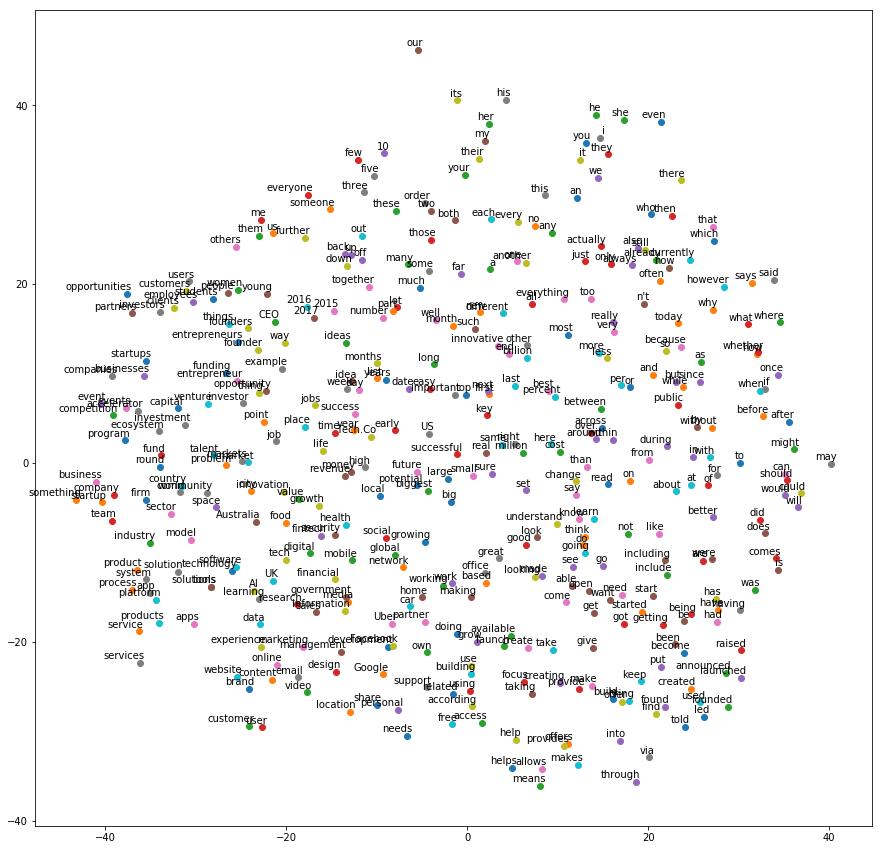

In [16]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [34]:
valid_examples = np.array(random.sample(range(valid_window), valid_size))
np.append(valid_examples,2253)

array([  63,   28,   64,   19,   38,    1,   17,   54,   40,   37,   45,
         27,   62,    6,   65,   50, 2253])

In [73]:
embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
embeddings[0] = tf.Variable( tf.random_uniform([128],0.0,1.0) )

TypeError: 'Variable' object does not support item assignment

In [72]:
tf.random_uniform([128],-1.0,1.0)

<tf.Tensor 'random_uniform_14:0' shape=(128,) dtype=float32>